# Feature selection

Perform feature selection to find the best set of features for out Machine learning models.   
Because irrelavant features can:
- **Increase Model Complexity**: Because necessary features can lead to overfitting, where the model performs well on training data but poorly on unseen data.
- **Reduce Model Interpretability**: A large number of features makes it difficult to understand how the model arrives at its predictions.
- **Slow Down Training Time**: Training models with irrelevant features takes longer and consumes more computational resources.

### Table of Contents
- [Essential Data Processing Techniques](#essential-data-processing-techniques)  

- [Filter Methods](#filter-methods)
    - [Correlation coefficient](#correlation-coefficient)  
    - [Chi-Square test](#chi-square-test)
    - [ANOVA F-test](#anova-f-test)  
    - [Information Gain](#information-gain)

- [Wrapper Methods](#wrapper-methods)
   - [Forward Selection](#forward-feature-selection)
   - [Backward Elimination](#backward-feature-elimination)
   - [Recursive Feature Elimination](#recursive-feature-elimination)

- [Embedded Methods](#embedded-methods)
    - [LASSO Regularisation (L1)]()

- [Advanced Methods](#advanced-methods)
    - [PCA](#pca)


Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_cleaning as dc
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from data_cleaning import get_Xy, med_impute, normalise, drop_high_corr

In [2]:
# Acess dataframe from EDA step
df_to_share = pd.read_pickle("df_to_share.pkl")
df_to_share.head()
df = df_to_share.copy()

## Essential Data Processing techniques

In [3]:
def process0(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return X_scaled_df, y


# function to pre-process the data
def process1(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return drop_high_corr(X_scaled_df), y


# function to obtain train and test sets
def process2(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

    return X_train, X_test, y_train, y_test


# function to obtain train and test sets with sythesised instances of the minority class
def pre_process(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    smote = SMOTE(random_state=3244)
    X_smote, y_train = smote.fit_resample(X_train, y_train)

    return X_smote, X_test, y_train, y_test


#### my functions
def preprocess(df):
    X, y = get_Xy(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    return X_train, X_test, y_train, y_test


def preprocess_with_SMOTE(df):
    X, y = get_Xy(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    smote = SMOTE(random_state=3244)
    X_smote, y_train = smote.fit_resample(X_train, y_train)
    return X_smote, X_test, y_train, y_test

---

# Filter Methods

Filter method is a feature selection method in the preprocessing step, and it is independent of the machine learning algorithm deployed afterwards. In our case, we implemented two filtering method, based on Information Gain (IG) and Correlation respectively.

1. **Correlation**
2. **Information Gain (IG)**

For both functions, we sort the features based on their scores in descending order. Higher scores indicate more important features.

For better judging the optimal number of feature, we define a function `plot_feature_performance` to evaluate the performance of a model (balanced Random Forest as example) as we vary the number of top features used. Finally, it plots the performance metrics f1 and recall against the number of features. With the aid of the plot, we determine the point of diminishing return through elbow method, selecting the optimal number of features.

## Correlation Coefficient
If two features are correlated, we can predict one feature from the other. Hence, we can drop one of the feature, as the second one does not add additional information.  

Here, we set the correlation threshold for highly correlated features as `0.7`. If two features are highly correlated, we can drop the feature with a lower correlation coefficient value to the target variable.  However, this is not applicable in our case since our target variable is a categorical variable.   

We can also check for multicollinearity for correlation between more than 2 features. 

Formula for Pearson's correlation coefficient between two variables $X$ and $Y$ with $n$ observations is calculated as:

$$ r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}} $$

where:
- $X_{i}$ and $Y_{i}$ are the individual observations of variables $X$ and $Y$, respectively.
- $\bar{X}$ and $\bar{Y}$ are the means of variables $X$ and $Y$, respectively.

This formula computes the normalized covariance between $X$ and $Y$, indicating the strength and direction of their linear relationship.

In [4]:
df_graph = df.copy()
X_train, X_test, y_train, y_test = preprocess(df_graph)

In [5]:
# Correlation matrix for all predictive features in the training dataset
cor = X_train.corr()
cor.head()

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets
net profit / total assets,1.000000,-0.156634,-0.085682,0.084549,-0.000048,-0.076792,0.998983,0.068546,-0.170848,-0.083644,...,0.014363,0.000649,0.011124,-0.004734,-0.003650,0.022305,-0.123055,0.013359,0.047738,0.026280
total liabilities / total assets,-0.156634,1.000000,-0.393118,-0.584570,-0.010638,-0.388317,-0.160653,-0.638698,0.132336,-0.400261,...,-0.120096,-0.010140,-0.011731,0.034823,0.027082,-0.022796,-0.016456,0.047916,-0.535595,0.090744
working capital / total assets,-0.085682,-0.393118,1.000000,0.039559,0.005045,0.998513,-0.085038,0.020615,0.012187,0.999699,...,0.005801,0.000160,0.000138,-0.000318,-0.000163,0.001356,0.008271,-0.132726,0.042981,0.007555
current assets / short-term liabilities,0.084549,-0.584570,0.039559,1.000000,0.005811,0.029413,0.088029,0.788652,-0.077846,0.036760,...,0.096485,0.003048,0.011537,-0.051189,-0.022130,-0.025635,-0.006583,0.007086,0.654201,0.032038
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,-0.000048,-0.010638,0.005045,0.005811,1.000000,0.004965,0.000080,0.006431,-0.006188,0.005145,...,0.000761,-0.000167,-0.000089,0.000056,0.000181,0.005990,-0.009692,-0.000575,0.006243,-0.002449


<Axes: >

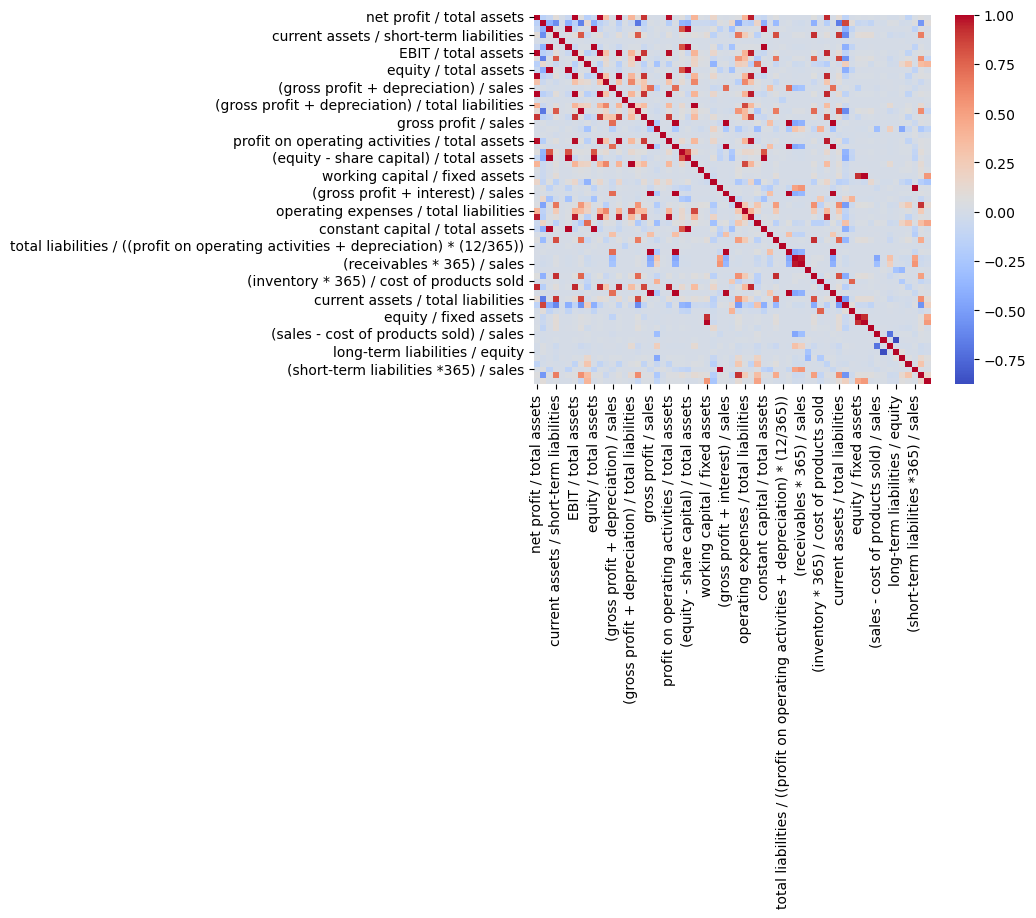

In [6]:
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm")

In [7]:
from data_cleaning import drop_high_corr, drop_corr_columns_from_test

print("Before dropping high correlated features: ", X_train.shape)

X_train_dropped, dropped_features = drop_high_corr(X_train, threshold=0.7)
X_test_dropped = drop_corr_columns_from_test(X_test, dropped_features)

print("After dropping high correlated features: ", X_train_dropped.shape)

Before dropping high correlated features:  (7350, 63)
After dropping high correlated features:  (7350, 29)


Observation:  
- 34 features are dropped 

## Chi-square test
Measures the independence between categorical features and the target variable.
Since we do not have independent features in our dataset, we shall not use Chi-Square test for feature selection. 

## ANOVA F-test
**ANOVA (Analysis of Variance)** is a statistical test used in feature selection to identify features that have a significant influence on the target variable. 

Steps to select the best k features (where k is a chosen number):
- Focuses on Variance: 
    - ANOVA analyses the variation in a feature's values. It compares the variation between groups (bankrupt vs. non-bankrupt) to the variation within each group.
- Low p-value indicates Impact: 
    - Features with a low p-value (from the F-statistic) suggest a strong statistical difference in the feature's values between bankrupt and non-bankrupt companies. This implies the feature likely has a real impact on predicting bankruptcy.

In [8]:
def plot_ANOVA_test_graph(train_acc_dict, test_acc_dict):
    # Extract keys and values from train_acc_dict and test_acc_dict
    train_k_values, train_accuracy_values = zip(*train_acc_dict.items())
    test_k_values, test_accuracy_values = zip(*test_acc_dict.items())

    plt.figure(figsize=(6, 4))
    # Plot train accuracy
    plt.plot(
        train_k_values, train_accuracy_values, label="Train Accuracy", color="blue"
    )
    # Plot test accuracy
    plt.plot(test_k_values, test_accuracy_values, label="Test Accuracy", color="green")

    # Find k values corresponding to maximum accuracies
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)
    best_train_accuracy = train_acc_dict[best_train_k]
    best_test_accuracy = test_acc_dict[best_test_k]

    # Annotate the point corresponding to the peak train accuracy
    plt.annotate(
        f"Max Train Accuracy\nk={best_train_k}, Acc={best_train_accuracy:.2f}",
        xy=(best_train_k, best_train_accuracy),
        xytext=(-30, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="blue"),
    )

    # Annotate the point corresponding to the peak test accuracy
    plt.annotate(
        f"Max Test Accuracy\nk={best_test_k}, Acc={best_test_accuracy:.2f}",
        xy=(best_test_k, best_test_accuracy),
        xytext=(30, -30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    # Label axes and add title
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Number of Features from ANOVA test")

    plt.legend()
    plt.show()


## Note: *args follow the convention X_train, X_test, y_train, y_test
def get_df_with_top_k_features(k_features, *args):  # after pre_process(df)
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # define feature selection
    fs = SelectKBest(score_func=f_classif, k=k_features)

    # apply feature selection
    fs.fit_transform(X_train, y_train)

    # Take the features with the highest F-scores
    fs_scores_array = np.array(fs.scores_)

    # Get the indices that would sort the array in descending order
    sorted_indices_desc = np.argsort(fs_scores_array)[::-1]

    # Take the top k indices
    top_indices = sorted_indices_desc[:k_features]

    selected_columns_X_train = X_train.iloc[:, top_indices]
    selected_columns_X_test = X_test.iloc[:, top_indices]

    return selected_columns_X_train, selected_columns_X_test, y_train, y_test

In [9]:
def find_best_k_features_from_ANOVA(model, *args):
    X_train = args[0]
    original_n_features = len(X_train[0].columns)

    train_acc_dict = {}  # 0 is a dummy accuracy for k=0 features
    test_acc_dict = {}
    train_test_dataset = {}

    for k in range(1, original_n_features + 1):
        print(f"k: {k}")
        train_test_dataset_after_ANOVA = get_df_with_top_k_features(k, *args)
        train_accuracy, test_accuracy = model(*train_test_dataset_after_ANOVA)
        train_test_dataset[k] = train_test_dataset_after_ANOVA
        train_acc_dict[k] = train_accuracy
        test_acc_dict[k] = test_accuracy

    # Find k that gives the highest accuracy
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)

    print(f"\033[96mBest k for train_accuracy:\033[00m {best_train_k}")
    print(f"\033[96mBest k for test_accuracy:\033[00m {best_test_k}")

    plot_ANOVA_test_graph(train_acc_dict, test_acc_dict)

    return train_test_dataset[best_test_k]

### Using ANOVA test on our dataset

In [15]:
def train_and_evaluate_svm(*args, params):
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # Create a SVM modelsvm = SVC(kernel=kernel, random_state=3244)
    svm_model = SVC(**params)
    svm_model.fit(X_train, y_train)

    # Calculate the accuracy of the model
    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)

    return train_accuracy, test_accuracy

def train_and_evaluate_svm(params, *args):
    svm_model = SVC(**params)
    train_accuracy, test_accuracy = dc.train_and_evaluate_model(svm_model, *args)
    return train_accuracy, test_accuracy

In [16]:
from sklearn import svm

train_test_dataset = preprocess(df)
train_test_smote_dataset = preprocess_with_SMOTE(df)

svm_param = {"kernel": ["sigmoid"]}
train_and_evaluate_svm(svm_param, *train_test_dataset)

AttributeError: module 'data_cleaning' has no attribute 'train_and_evaluate_model'

In [11]:
from sklearn.svm import SVC
import data_cleaning as dc

train_test_dataset = preprocess(df)
train_test_smote_dataset = preprocess_with_SMOTE(df)

# Example of using the function
best_k = dc.find_best_k_features_from_ANOVA(train_and_evaluate_svm, *train_test_dataset)
#best_k_smote = dc.find_best_k_features_from_ANOVA(train_and_evaluate_svm, *train_test_smote_dataset)
best_k
b#est_k_smote

IndexError: tuple index out of range

In [13]:
svm_model

SVC()

## Information Gain

Measures the reduction in entropy from transforming a dataset in some way. It is often used in training decision trees. Information Gain can be applied to feature selection by evaluating the mutual information between each feature and the target variable. Features that have higher mutual information with the target variable are considered more informative and are thus selected.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score


def information_gain(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def correlation_selection(X, y):
    if isinstance(y, pd.Series):
        y = y.to_frame(name="Target")
    elif isinstance(y, pd.DataFrame):
        y.columns = ["Target"]

    df_combined = pd.concat([X, y], axis=1)
    correlation_matrix = df_combined.corr()
    correlation_w_target = correlation_matrix["Target"].drop("Target")
    return correlation_w_target.abs().sort_values(ascending=False)


def plot_feature_performance(X, y, score_series, model, max_features=None):
    f1_results = []
    recall_results = []
    feature_counts = []

    if not max_features:
        max_features = len(score_series)

    for i in range(1, max_features + 1):
        top_features = score_series.nlargest(i).index
        X_selected = X[top_features]

        # Cross-validation F1 and recall scores
        f1 = cross_val_score(model, X_selected, y, cv=5, scoring="f1")
        recall = cross_val_score(model, X_selected, y, cv=5, scoring="recall")

        f1_results.append(f1.mean())
        recall_results.append(recall.mean())
        feature_counts.append(i)

    # Plotting the F1-score and recall results
    plt.figure(figsize=(10, 6))
    plt.plot(
        feature_counts,
        f1_results,
        marker="o",
        linestyle="-",
        markersize=8,
        label="F1 Score",
    )
    plt.plot(
        feature_counts,
        recall_results,
        marker="o",
        linestyle="-",
        markersize=8,
        label="Recall",
    )
    plt.xlabel("Number of Features")
    plt.ylabel("Score")
    plt.title("Model Performance vs. Number of Features")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Example of using the function
train_test_dataset = preprocess(df)
train_test_smote_dataset = preprocess_with_SMOTE(df)

svm_model = SVC(kernel="sigmoid")

---

## Wrapper Methods
Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

Wrapper methods:
1. Forward Feature Selection
2. Backward Feature Elimination
3. Exhaustive Feature Selection
4. Recursive Feature Elimination

The wrapper method for feature selection is a technique used to identify the most significant features for a predictive model. It works by starting with an empty set and adding features one by one, each time choosing the feature that, when added, most improves the model's F1 score - our desirable metric. This approach is iterative and selects features based on their contribution to the model's predictive accuracy.

### Forward Feature Selection

In [ ]:
from sklearn.metrics import f1_score


def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    selected_features = []
    best_f1 = 0
    features = list(X_train.columns)

    for _ in range(len(features)):
        f1_scores = []
        for feature in features:
            if feature not in selected_features:
                temp_features = selected_features + [feature]
                model.fit(X_train[temp_features], y_train)
                y_pred = model.predict(X_test[temp_features])
                f1 = f1_score(y_test, y_pred)
                f1_scores.append((feature, f1))

        # Find the best feature and its f1 score
        f1_scores.sort(key=lambda x: x[1], reverse=True)
        best_feature, best_feature_f1 = f1_scores[0]

        if best_feature_f1 > best_f1:
            print(f"Adding {best_feature} improved F1 to {best_feature_f1}")
            best_f1 = best_feature_f1
            selected_features.append(best_feature)
        else:
            break

    print("Selected features:", selected_features)
    return selected_features

In [ ]:
# Example of using the function
train_test_dataset = preprocess(df)
train_test_smote_dataset = preprocess_with_SMOTE(df)

svm_model = SVC(kernel="sigmoid")
forward_feature_selection(svm_model, train_test_dataset)

## Backward Feature Elimination

## Recursive Feature Elimination

---

## Embedded Methods
These methods encompass the benefits of both the wrapper and filter methods by including interactions of features but also maintaining reasonable computational costs. Embedded methods are iterative in the sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration.

Example techniques:
1. LASSO Regularisation (L1)
2. Random Forest Importance


---

# Advanced Methods
1. Principal Component Analysis (PCA): 
    - Reduces the dimensionality of the data by transforming it into a new set of features that are linear combinations of the original features.
2. Independent Component Analysis (ICA): 
    - Similar to PCA, but focuses on making the components statistically independent rather than uncorrelated.
3. Factor Analysis: 
    - Identifies underlying relationships between features by modeling the observed variables as linear combinations of potential factors.
4. t-Distributed Stochastic Neighbor Embedding (t-SNE): 
    - Primarily used for visualization but can help in understanding the structure of the data for feature selection.
5. Autoencoders: 
    - Uses neural networks to learn a compressed representation of the data, which can be used for feature selection.

## PCA